In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import tensorflow as tf
import os

In [2]:
tf.config.list_physical_devices('GPU') #tf version 2.*
#tf.test.is_gpu_available() #tf version 1.*

# restrict gpu usage to 1 GPU
#os.environ["CUDA_DEVICE_ORDER"]#="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]#="0"

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
from utilities.utils import *
from utilities.config import *
from utilities.visualize import *
from utilities.model import *

### Configuration

In [4]:
from config import *

Config.display()


alpha: 0.02
batch_size: 1000
dim_clusters: 64
dropout_d: 0.0
dropout_g: 0.0
learning_rate_d: 0.001
learning_rate_g: 0.001
n_clusters: 1
n_epochs: 300
n_hidden_units_d: 300
n_hidden_units_g: 300
n_steps: 30
reg_strength_d: 0.0
reg_strength_g: 0.0
sigma_clusters: 1


### Model

In [5]:
########
# Discriminator Model
########

d_in = tf.keras.Input(shape=(Config.n_steps,1))
d_out = discriminator(d_in)
Discriminator_base = tf.keras.Model(inputs=d_in, outputs=d_out)


########
# Trainable Discriminator
########

Discriminator      = tf.keras.Model(inputs=Discriminator_base.inputs, outputs=Discriminator_base.outputs)
Discriminator.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(lr=Config.learning_rate_d))

########
#GAN stack - Trainable Generator and Frozen Discriminator
########
g_in = tf.keras.Input(shape=(Config.n_steps,Config.n_clusters+Config.dim_clusters))
g_out = generator(g_in)

Generator           = tf.keras.Model(inputs=g_in, outputs=g_out)
Discriminator_frozen= tf.keras.Model(inputs=Discriminator_base.inputs, outputs=Discriminator_base.outputs)
Discriminator_frozen.trainable = False

gan_in = tf.keras.Input(shape=(Config.n_steps,Config.n_clusters+Config.dim_clusters))
generated = Generator(gan_in)
gan_out = Discriminator_frozen(generated)
GAN = tf.keras.Model(inputs = gan_in, outputs = gan_out)
GAN.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(lr=Config.learning_rate_g))





### Summary

In [6]:
#Generator.summary()
#Discriminator_frozen.summary()
GAN.summary()
Discriminator.summary()



Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 30, 65)]          0         
_________________________________________________________________
functional_5 (Functional)    (None, 30, 1)             660901    
_________________________________________________________________
functional_7 (Functional)    (None, 30, 1)             545701    
Total params: 1,206,602
Trainable params: 660,901
Non-trainable params: 545,701
_________________________________________________________________
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 1)]      0                                            
___________________________________________________

### Training Dataset

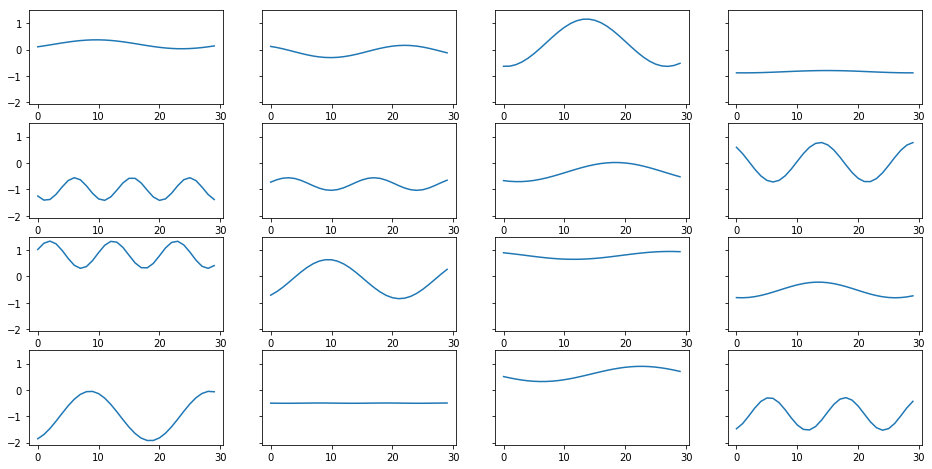

In [7]:
x_train = create_sine_dataset()
n_batches = x_train.shape[0] // Config.batch_size
d_loss_list = []
g_loss_list = []
sines_plot(x_train,4,4)

### Training

In [ ]:
for epoch in range(Config.n_epochs):
    x_train = create_sine_dataset()
    for batch in range(n_batches):
        if batch % 1 == 0:
            z_c,z_n = categorical_noise()
            z = np.concatenate([z_c,z_n],axis = 2)
            g_labels = np.zeros((Config.batch_size,Config.n_steps))[:,:,None]
            g_loss = GAN.train_on_batch(z, g_labels)
        

        z_c,z_n = categorical_noise()
        z = np.concatenate([z_c,z_n],axis = 2)
        generated = Generator.predict(z)

        d_loss_gen = Discriminator.train_on_batch(generated,
                                              np.ones((Config.batch_size,Config.n_steps,1)))
        d_loss_real = Discriminator.train_on_batch(x_train[batch*Config.batch_size:(batch+1)*Config.batch_size,0:Config.n_steps,None],
                                              np.zeros((Config.batch_size,Config.n_steps,1)))
        d_loss_list += [0.5*(d_loss_real + d_loss_gen)]
        g_loss_list += [g_loss]
        if batch%50 == 0: 
            
            print("Discriminator loss on generated samples: ", d_loss_gen)
            print("Discriminator loss on real samples: ", d_loss_real)
            print("Generator loss: ", g_loss)
            sines_plot(generated,1,1)


### Plots

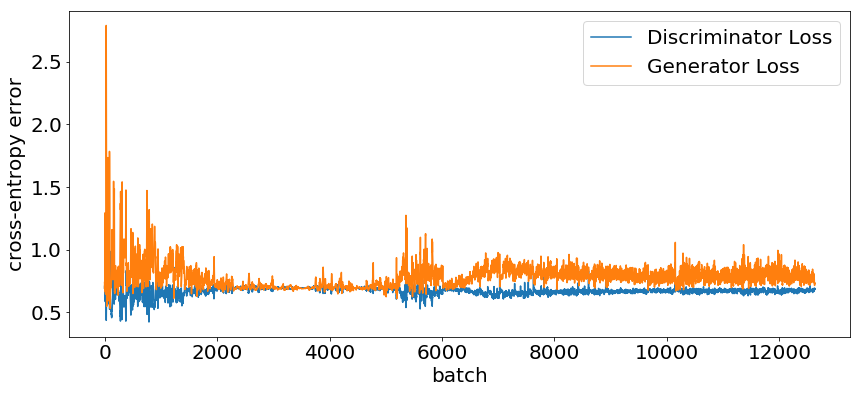

In [10]:
mpl.rc('xtick', labelsize=20) 
mpl.rc('ytick', labelsize=20) 

fig = plt.figure()
fig.set_size_inches(14, 6)
plt.plot(d_loss_list,label='Discriminator Loss')
plt.plot(g_loss_list,label='Generator Loss')

plt.legend(prop={'size': 20})
plt.xlabel('batch', fontsize = 20)
plt.ylabel('cross-entropy error', fontsize = 20)
plt.show()

# reset labelsize
mpl.rc('xtick', labelsize=10) 
mpl.rc('ytick', labelsize=10) 


In [ ]:
### Prepare Test Model and Test Data

Example Training Data:


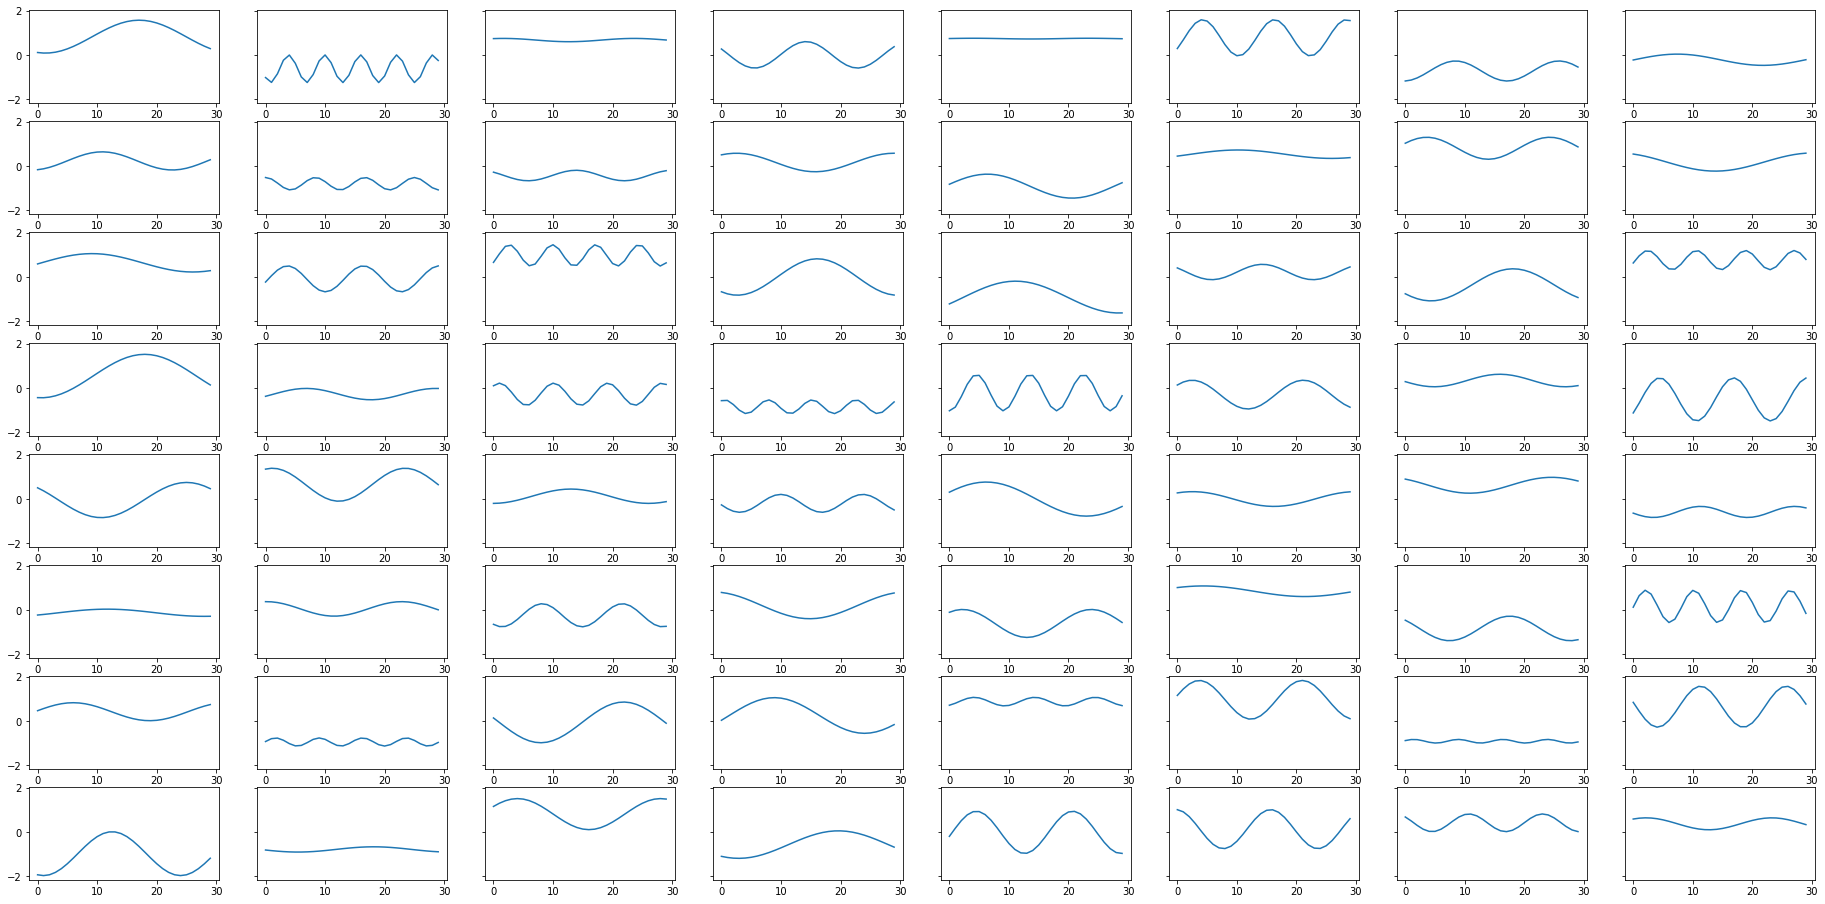

Generated Data:


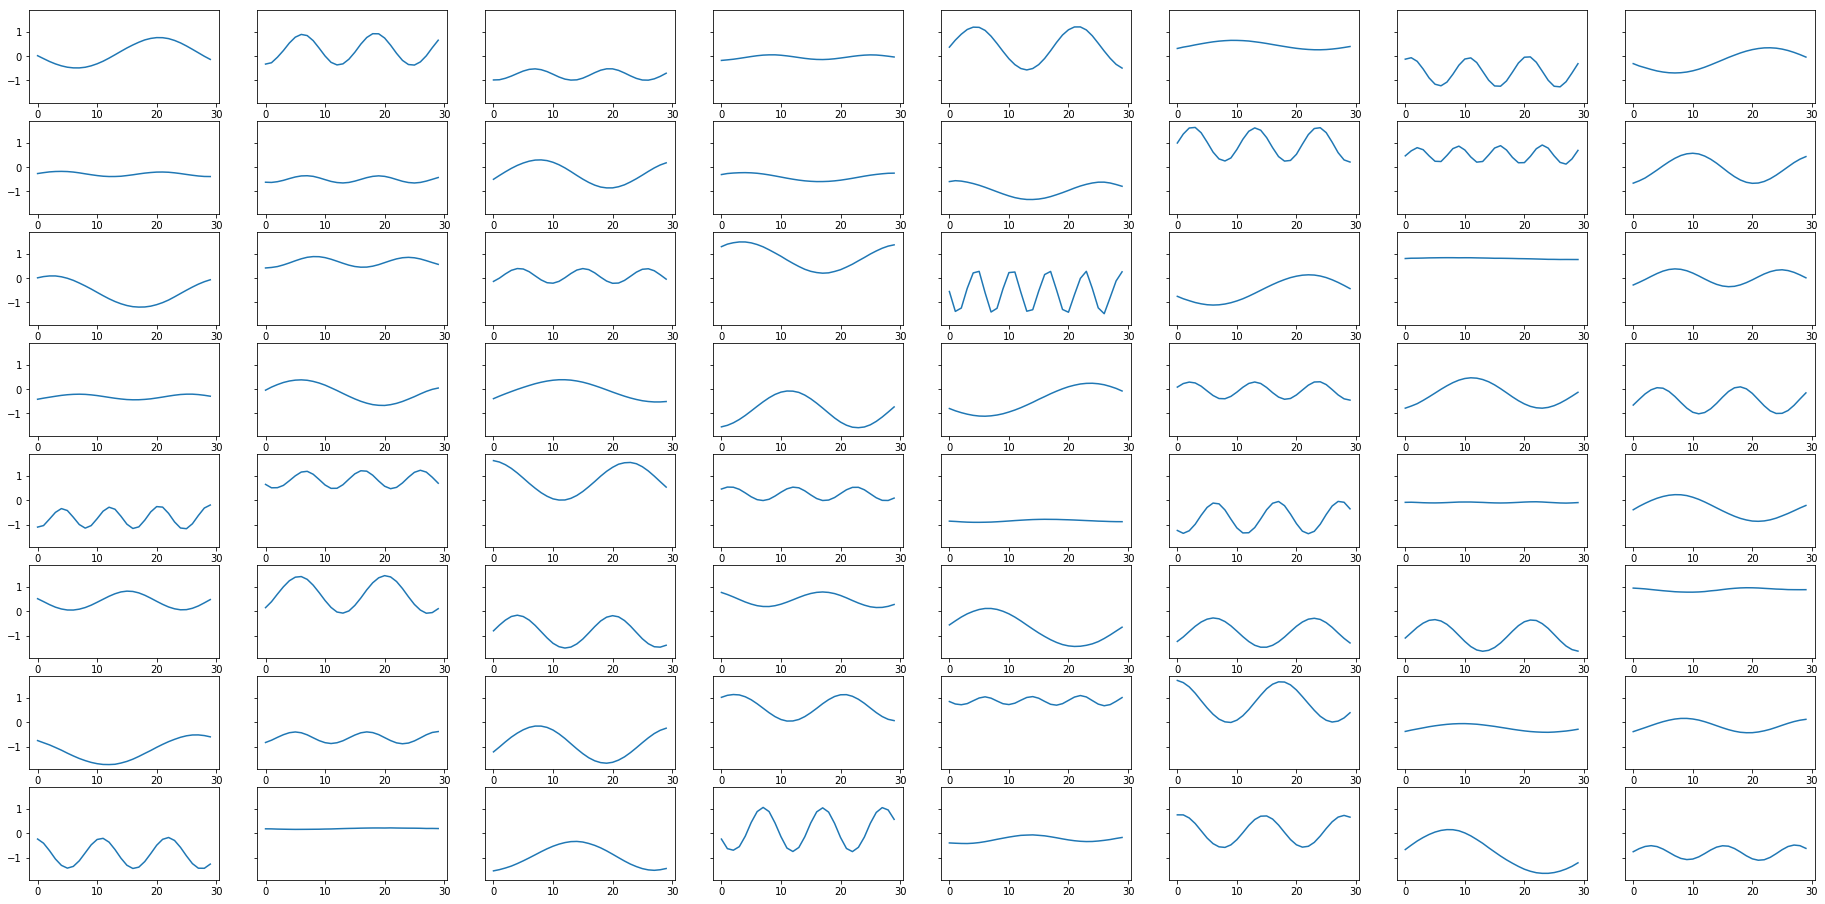

Generated Data - Generalization to longer Sequences:


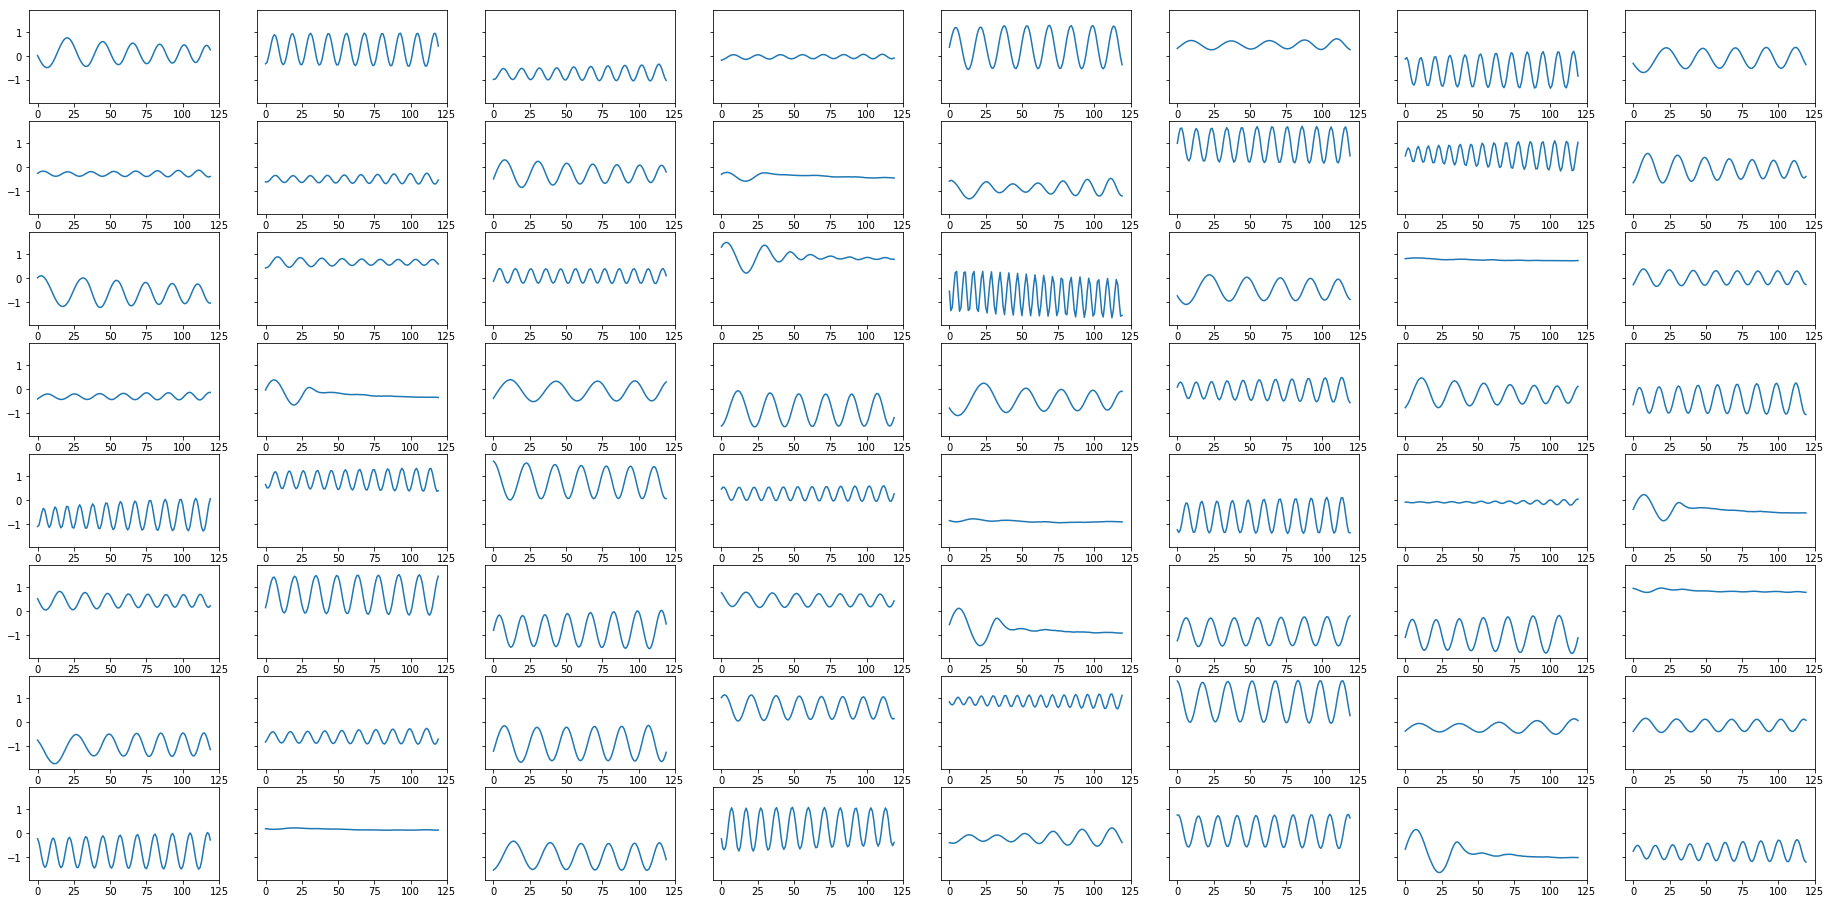

In [12]:
# Testmodel
# Generator for longer sequences than during training
test_in = tf.keras.Input(shape=(Config.n_steps*4,Config.n_clusters+Config.dim_clusters))
test_out = generator(test_in)
Generator_long = tf.keras.Model(inputs=test_in, outputs=test_out)
Generator_long.set_weights(Generator.get_weights())

# Testdata
z_c,z_n = categorical_noise()
z = np.concatenate([z_c,z_n],axis = 2)

# longer sequence of input noise
z_long = np.concatenate([z,z,z,z], axis = 1)


# Plots
test_output = Generator.predict(z)
test_output_long = Generator_long.predict(z_long)
print("Example Training Data:")
sines_plot(x_train,8,8)
print("Generated Data:")
sines_plot(test_output,8,8)
print("Generated Data - Generalization to longer Sequences:")
sines_plot(test_output_long,8,8)

In [ ]:
#z_c = np.zeros((Config.batch_size, Config.n_steps, Config.n_clusters)).astype("float32")
#for i in range(Config.n_clusters):
#    z_c[i:i+1,:,i] = 1

126